In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

In [0]:
! pip install -q kaggle


In [0]:
from google.colab import files
files.upload()

In [60]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d weixinxu666/digit-recognizer

mkdir: cannot create directory ‘/root/.kaggle’: File exists
digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile
local_zip = "digit-recognizer.zip"
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('./database')
zip_ref.close()

Load the data

In [0]:
train = pd.read_csv("/content/database/train.csv")
test = pd.read_csv("/content/database/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

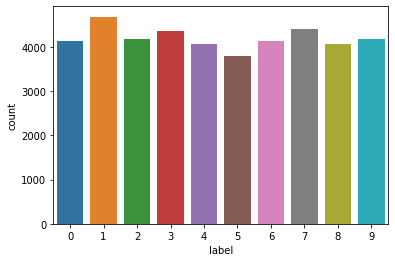

In [63]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"], axis = 1)
g = sns.countplot(Y_train)
Y_train.value_counts() 

In [64]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [65]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Now Normalization the test and train set to convert images into Grayscale.

In [0]:
X_train = X_train / 255.0
test = test / 255.0

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [0]:
X_train = X_train.values.reshape(-1, 28, 28,1)
test = test.values.reshape(-1, 28, 28, 1)

Checking the shape of the train and test images

In [68]:
print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


Visualizing the image of test and train as a sample

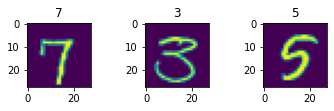

In [69]:
for i in range(6,9):
  plt.subplot(330 + (i+1))
  plt.imshow(X_train[i][:,:,0])
  plt.title(Y_train[i]);

Lable encoding to conver into image into vector using to_categorical

In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

Now Splitting training and Validation set

In [0]:
from sklearn.model_selection import train_test_split
#Defining random_seed number
random_seed=2
X_train, X_val, Y_train, Y_val= train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Note: It is important to randomise the splitting of the training and validation data. For example if the test_size = 0.1, the validation data set will only contain 8 and 9, mostly 9 while the training set will contain all the numbers apart from number 9. How can the training set predict 9 in the validation set?

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

CNN
Define the model

Keral Sequential API: add on layer at a time, starting from the input.

CNN architecture is -> 
1. [[Conv2D-> relu]
2. MaxPool2D
3. Dropout
4. Flatten
5. Dense
6. Dropout
7. Out

The first is the convolution(Conv2D) layer. It is for the learnable filters. I choose to set 32 filters for the first conv2D layers and 64 filters for the two last ones. Each filter transform a part of the image 



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).


In [0]:
# Defining the optimizer first
from keras.optimizers import RMSprop
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

In [0]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, I used an annealing method of the learning rate(LR).
The LR is the step by which the optimizer walks through the loss landscape. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with a high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the globa; minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, I decreased LR dynamically every X steps (epochs) depending if it is necessary.

Epochs vs LR

1. The learning rate contrls how quickly the model is adapted to the problem. Smaller learning rate require more training epochs given the smaller changes made to weight each update, whereas larger learning rates result in rapid cahnges and require fewer training epochs.

2. A learning rate that is too large can cause the model to coverge too quickly to the suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

What is Epochs?

1 Epoch = 1 Forward pass + 1 Backward pass for ALL training samples.
Batch Size = Number of training samples in 1 Forward/1 Backward pass. (With increase in Batch size, required memory space increases.)
Number of iterations = Number of passes i.e. 1 Pass = 1 Forward pass + 1 Backward pass (Forward pass and Backward pass are not counted differently.)
Example : If we have 1000 training samples and Batch size is set to 500, it will take 2 iterations to complete 1 Epoch.
With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.





In [0]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor="val_acc", patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [0]:
epochs = 10
batch_size = 86

Data Augmentation

In order to avoid overfitting problem, we need to expand artifically.Our handrwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variation occuring whwn someone is writing a digit.

For example, the number is not centered, or if the scale is not the same(size is different), the image is rotated.

Approches the alter the training in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation: 98.114% accuracy
With data augmentation: 99.67% accuracy

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

We can configure the batch size and prepare the data generator and get batches of images by calling the flow() function.

X_batch, y_batch = datagen.flow(train, train, batch_size=32)
Finally we can make use of the data generator. Instead of calling the fit() function on our model, we must call the fit_generator() function and pass in the data generator and the desired length of an epoch as well as the total number of epochs on which to train.

fit_generator(datagen, samples_per_epoch=len(train), epochs=100)
Previously defined: epochs = 30 batch_size = 86

In [78]:
# Fit the model
history=model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
 - 255s - loss: 0.4229 - accuracy: 0.8645 - val_loss: 0.0517 - val_accuracy: 0.9845
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 256s - loss: 0.1245 - accuracy: 0.9618 - val_loss: 0.0424 - val_accuracy: 0.9876
Epoch 3/10
 - 255s - loss: 0.0962 - accuracy: 0.9713 - val_loss: 0.0423 - val_accuracy: 0.9883
Epoch 4/10
 - 256s - loss: 0.0825 - accuracy: 0.9754 - val_loss: 0.0318 - val_accuracy: 0.9893
Epoch 5/10
 - 252s - loss: 0.0761 - accuracy: 0.9775 - val_loss: 0.0260 - val_accuracy: 0.9914
Epoch 6/10
 - 253s - loss: 0.0695 - accuracy: 0.9797 - val_loss: 0.0221 - val_accuracy: 0.9931
Epoch 7/10
 - 256s - loss: 0.0676 - accuracy: 0.9803 - val_loss: 0.0220 - val_accuracy: 0.9938
Epoch 8/10
 - 252s - loss: 0.0651 - accuracy: 0.9814 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 9/10
 - 256s - loss: 0.0629 - accuracy: 0.9823 - val_loss: 0.0209 - val_accuracy: 0.9929
Epoch 10/10
 - 252s - loss: 0.0595 - accuracy: 0.9835 - val_loss: 0.0178 - val_accuracy: 0.9933


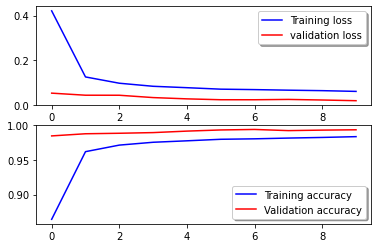

In [80]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

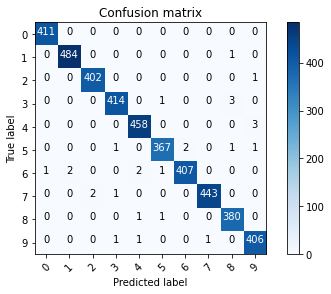

In [88]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the digit 4,which is sometimes misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

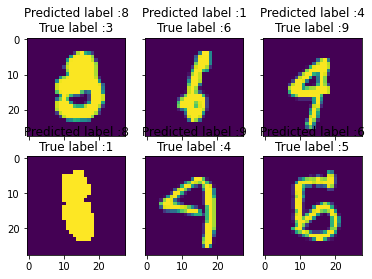

In [89]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]


def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)